In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2021-11-14 12:46:43--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.85.165
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.85.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  12.6MB/s    in 1.0s    

2021-11-14 12:46:44 (12.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [2]:
!unzip 'jena_climate_2009_2016.csv.zip'

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
import os

data_dir = '/content'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


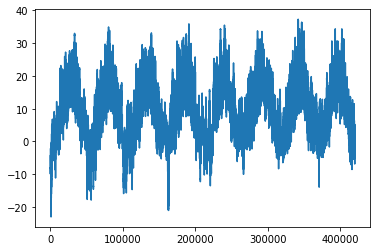

In [4]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

from matplotlib import pyplot as plt

temp = float_data[:, 1] #temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

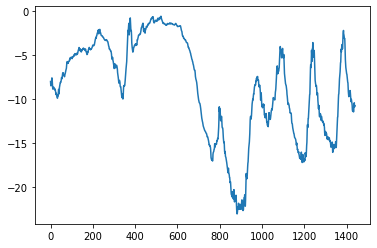

In [5]:
plt.plot(range(1440), temp[:1440])

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [7]:
float_data

array([[ 0.90014748, -1.93135845, -1.98211036, ..., -0.72950452,
        -0.78067973, -0.27613603],
       [ 0.9060434 , -1.97541381, -2.02567   , ..., -0.93124017,
        -0.88794488, -0.46317443],
       [ 0.90132666, -1.98671006, -2.03683914, ..., -1.27614304,
        -1.26122763, -0.05330633],
       ...,
       [ 1.28927851, -1.38236094, -1.46721307, ..., -0.69696652,
        -0.67341457,  0.45008097],
       [ 1.28809932, -1.50323076, -1.58672285, ..., -0.43015486,
        -0.60476487,  0.57246412],
       [ 1.28927851, -1.56987861, -1.65150386, ..., -0.5993525 ,
        -0.690577  ,  0.10024989]])

In [8]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step, 
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [11]:
print(val_steps)

769


In [12]:
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))
  
evaluate_naive_method()

0.2897359729905486


In [13]:
celsius_mae = 0.29 * std[1]

In [14]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')


In [15]:
history = model.fit(train_gen,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
100/100 [==============================] - 12s 116ms/step - loss: 2.4895 - val_loss: 1.6924
Epoch 2/20
100/100 [==============================] - 11s 115ms/step - loss: 1.5460 - val_loss: 1.1413
Epoch 3/20
100/100 [==============================] - 11s 115ms/step - loss: 1.1967 - val_loss: 0.7340
Epoch 4/20
100/100 [==============================] - 11s 115ms/step - loss: 0.9041 - val_loss: 0.8587
Epoch 5/20
100/100 [==============================] - 11s 115ms/step - loss: 0.6997 - val_loss: 0.4920
Epoch 6/20
100/100 [==============================] - 11s 114ms/step - loss: 0.5418 - val_loss: 0.4889
Epoch 7/20
100/100 [==============================] - 11s 115ms/step - loss: 0.4398 - val_loss: 0.3804
Epoch 8/20
100/100 [==============================] - 11s 115ms/step - loss: 0.3711 - val_loss: 0.3484
Epoch 9/20
100/100 [==============================] - 11s 115ms/step - loss: 0.3346 - val_loss: 0.3264
Epoch 10/20
100/100 [==============================] - 11s 115ms/step - l

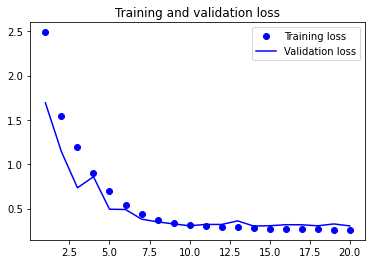

In [16]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
from keras.models import Sequential
from keras import layers
from  tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 65s 128ms/step - loss: 0.3012 - val_loss: 0.2715
Epoch 2/20
500/500 [==============================] - 63s 126ms/step - loss: 0.2834 - val_loss: 0.2652
Epoch 3/20
500/500 [==============================] - 64s 127ms/step - loss: 0.2759 - val_loss: 0.2624
Epoch 4/20
500/500 [==============================] - 64s 127ms/step - loss: 0.2697 - val_loss: 0.2623
Epoch 5/20
500/500 [==============================] - 63s 127ms/step - loss: 0.2649 - val_loss: 0.2636
Epoch 6/20
500/500 [==============================] - 64s 127ms/step - loss: 0.2608 - val_loss: 0.2702
Epoch 7/20
500/500 [==============================] - 64s 127ms/step - loss: 0.2556 - val_loss: 0.2642
Epoch 8/20
500/500 [==============================] - 64s 127ms/step - loss: 0.2498 - val_loss: 0.2670
Epoch 9/20
500/500 [==============================] - 64s 129ms/step - loss: 0.2466 - val_loss: 0.2676
Epoch 10/20
500/500 [==============================] - 64s 127ms/step - l

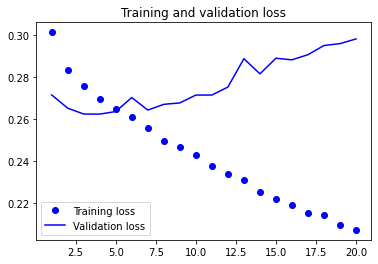

In [18]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,
dropout=0.2,
recurrent_dropout=0.2,
input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 116s 228ms/step - loss: 0.3266 - val_loss: 0.2818
Epoch 2/40
500/500 [==============================] - 114s 228ms/step - loss: 0.3090 - val_loss: 0.2778
Epoch 3/40
500/500 [==============================] - 114s 227ms/step - loss: 0.3019 - val_loss: 0.2785
Epoch 4/40
500/500 [==============================] - 114s 227ms/step - loss: 0.2982 - val_loss: 0.2721
Epoch 5/40
500/500 [==============================] - 114s 228ms/step - loss: 0.2936 - val_loss: 0.2693
Epoch 6/40
500/500 [==============================] - 114s 228ms/step - loss: 0.2895 - val_loss: 0.2702
Epoch 7/40
500/500 [==============================] - 114s 228ms/step - loss: 0.2834 - val_loss: 0.2779
Epoch 8/40
500/500 [==============================] - 114s 229ms/step - loss: 0.2807 - val_loss: 0.2722
Epoch 9/40
500/500 [==============================] - 115s 229ms/step - loss: 0.2785 - val_loss: 0.2731
Epoch 10/40
500/500 [==============================] - 114s 229m

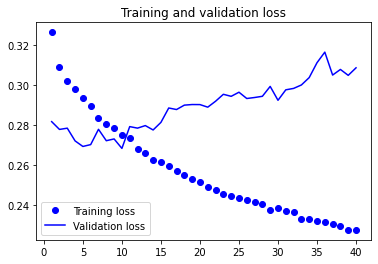

In [20]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

17473536/17464789 [==============================] - 0s 0us/step
Epoch 1/10
157/157 [==============================] - 77s 475ms/step - loss: 0.4855 - acc: 0.7695 - val_loss: 0.4018 - val_acc: 0.8534
Epoch 2/10
157/157 [==============================] - 74s 472ms/step - loss: 0.3021 - acc: 0.8860 - val_loss: 0.3171 - val_acc: 0.8866
Epoch 3/10
157/157 [==============================] - 74s 472ms/step - loss: 0.2555 - acc: 0.9075 - val_loss: 0.3162 - val_acc: 0.8848
Epoch 4/10
157/157 [==============================] - 75s 475ms/step - loss: 0.2163 - acc: 0.9236 - val_loss: 0.3208 - val_acc: 0.8714
Epoch 5/10
157/157 [==============================] - 74s 475ms/step - loss: 0.1906 - acc: 0.9326 - val_loss: 0.3358 - val_acc: 0.8668
Epoch 6/10
157/157 [==============================] - 74s 473ms/step - loss: 0.1693 - acc: 0.9417 - val_loss: 0.3547 - val_acc: 0.8870
Epoch 7/10
157/157 [==============================] - 74s 470ms/step - loss: 0.1590 - acc: 0.9474 - val_loss: 0.3663 - val_ac

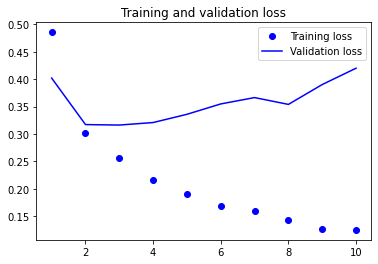

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 103s 634ms/step - loss: 0.5525 - acc: 0.7234 - val_loss: 0.3889 - val_acc: 0.8594
Epoch 2/10
157/157 [==============================] - 99s 631ms/step - loss: 0.3357 - acc: 0.8691 - val_loss: 0.4040 - val_acc: 0.8266
Epoch 3/10
157/157 [==============================] - 99s 631ms/step - loss: 0.2683 - acc: 0.9009 - val_loss: 0.4619 - val_acc: 0.8104
Epoch 4/10
157/157 [==============================] - 99s 632ms/step - loss: 0.2324 - acc: 0.9162 - val_loss: 0.3202 - val_acc: 0.8818
Epoch 5/10
157/157 [==============================] - 100s 635ms/step - loss: 0.1992 - acc: 0.9287 - val_loss: 0.4031 - val_acc: 0.8788
Epoch 6/10
157/157 [==============================] - 100s 634ms/step - loss: 0.1806 - acc: 0.9370 - val_loss: 0.3710 - val_acc: 0.8800
Epoch 7/10
157/157 [==============================] - 99s 631ms/step - loss: 0.1647 - acc: 0.9441 - val_loss: 0.3465 - val_acc: 0.8834
Epoch 8/10
157/157 [==============================] 

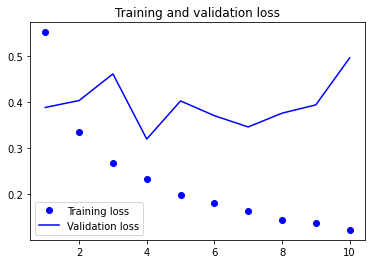

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 120s 234ms/step - loss: 0.2981 - val_loss: 0.2801
Epoch 2/20
500/500 [==============================] - 116s 231ms/step - loss: 0.2760 - val_loss: 0.2674
Epoch 3/20
500/500 [==============================] - 117s 233ms/step - loss: 0.2695 - val_loss: 0.2665
Epoch 4/20
500/500 [==============================] - 116s 233ms/step - loss: 0.2624 - val_loss: 0.2631
Epoch 5/20
500/500 [==============================] - 116s 233ms/step - loss: 0.2560 - val_loss: 0.2651
Epoch 6/20
500/500 [==============================] - 117s 234ms/step - loss: 0.2488 - val_loss: 0.2698
Epoch 7/20
500/500 [==============================] - 117s 235ms/step - loss: 0.2431 - val_loss: 0.2680
Epoch 8/20
500/500 [==============================] - 117s 234ms/step - loss: 0.2355 - val_loss: 0.2730
Epoch 9/20
500/500 [==============================] - 117s 234ms/step - loss: 0.2281 - val_loss: 0.2763
Epoch 10/20
500/500 [==============================] - 117s 234m

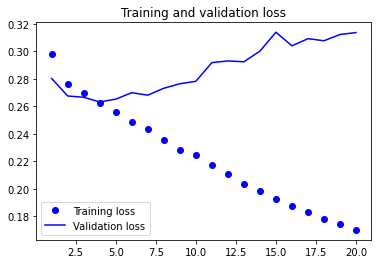

In [24]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()